In [120]:
import numpy as np
from scipy.special import softmax
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [125]:
class FairRegressionDiscret():
    def __init__(self, base_method, beta=1, L=20, num_iter=1000, M=10, weights=[.5, .5]):
        self.base_method = base_method
        self.beta = beta
        self.L = L
        self.num_iter = num_iter
        self.M = M
        self.weights = weights
    def fit(self, X_unlab):
        coef = np.zeros(2 * self.L + 1)
        moment = np.zeros(2 * self.L + 1)
        y_pred0 = self.base_method.predict(X_unlab[X_unlab[:,-1] == -1])
        y_pred1 = self.base_method.predict(X_unlab[X_unlab[:,-1] == 1])
        discr = np.arange(-self.L, self.L + 1) * self.M / self.L
        z0 = self.weights[0] * np.square(y_pred0[:, np.newaxis] - discr)
        z1 = self.weights[1] * np.square(y_pred1[:, np.newaxis] - discr)
        tau = 0
        for t in range(self.num_iter):
            tmp = (1 + np.sqrt(1 + 4 * tau ** 2)) / 2
            gamma = (1 - tau) / tmp
            tau = tmp
            coef_prev = coef
            coef = (moment - (self.beta / 2) * (np.mean(softmax((moment - z1) / self.beta, axis=1), axis=0) -
                                                np.mean(softmax((-moment - z0) / self.beta, axis=1), axis=0)))
            moment = (1 - gamma) * coef + gamma * coef_prev
        self.coef_ = coef
        self.discr_ = discr
    def predict(self, X):
        n_samples, _ = X.shape
        s = np.zeros(n_samples)
        s[X[:,-1] == -1] = -1
        s[X[:,-1] == 1] = 1
        z = np.square(self.base_method.predict(X)[:, np.newaxis] - self.discr_)
        z[X[:,-1] == -1, :] *= self.weights[0]
        z[X[:,-1] == 1, :] *= self.weights[1]
        return (np.argmin(-s[:,np.newaxis] * self.coef_ + z, axis=1) - self.L) * self.M / self.L

In [86]:
N_train = 500
thr = 0

X_train = np.random.normal(0, 1, (N_train, 3))
sens = np.zeros(N_train)
sens[X_train[:, 0] < thr] = -1
sens[X_train[:, 0] >= thr] = 1
sens = sens[:, np.newaxis]
X_train = np.append(X_train, sens, axis=1)
y_train = np.dot(X_train, np.ones(4) * 3) + np.random.normal(0, 1, N_train)


N_unlab = 1000
X_unlab = np.random.normal(0, 1, (N_unlab, 3))
sens = np.zeros(N_unlab)
sens[X_unlab[:, 0] < thr] = -1
sens[X_unlab[:, 0] >= thr] = 1
sens = sens[:, np.newaxis]
X_unlab = np.append(X_unlab, sens, axis=1)

In [87]:
ls = LinearRegression(fit_intercept=False)
ls.fit(X_train, y_train)


N_test = 1000
X_test = np.random.normal(0, 1, (N_test, 3))
sens = np.zeros(N_test)
sens[X_test[:, 0] < thr] = -1
sens[X_test[:, 0] >= thr] = 1
sens = sens[:, np.newaxis]
X_test = np.append(X_test, sens, axis=1)


In [162]:
fair_ls = FairRegressionDiscret(ls, M=15, weights=[.5, .5], L=30, num_iter=800, beta=1)
fair_ls.fit(X_unlab)

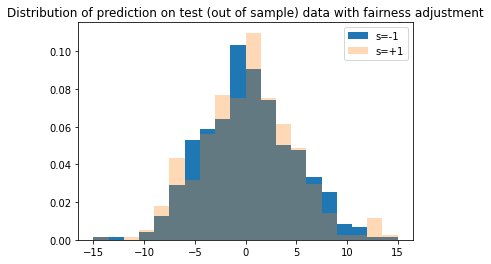

In [165]:
y_pred = fair_ls.predict(X_test)
y_pred0 = y_pred[X_test[:, -1] == -1]
y_pred1 = y_pred[X_test[:, -1] == 1]

plt.figure('1')
plt.hist(y_pred0, label='s=-1', density=True, stacked=True, bins=20)
plt.hist(y_pred1, label='s=+1', alpha=0.3, density=True, stacked=True, bins=20)
plt.title('Distribution of prediction on test (out of sample) data with fairness adjustment')
plt.legend()

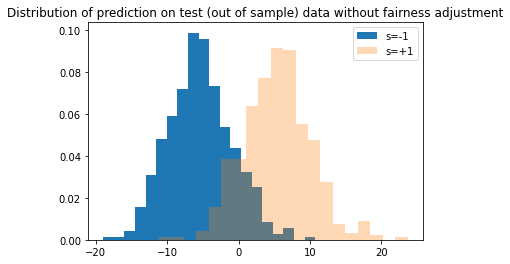

In [166]:
y_pred = ls.predict(X_test)
y_pred0 = y_pred[X_test[:, -1] == -1]
y_pred1 = y_pred[X_test[:, -1] == 1]

plt.figure('1')
plt.hist(y_pred0, label='s=-1', density=True, stacked=True, bins=20)
plt.hist(y_pred1, label='s=+1', alpha=0.3, density=True, stacked=True, bins=20)
plt.title('Distribution of prediction on test (out of sample) data without fairness adjustment')
plt.legend()